In [1]:
import torch
torch.set_default_tensor_type(torch.FloatTensor)
from torch.autograd import Variable
from torch.nn import functional as F
from torchmetrics import Accuracy, Recall, Precision, Specificity, ConfusionMatrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

from sklearn.metrics import precision_recall_curve, average_precision_score,roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score

import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import matplotlib.pyplot as plt
from collections import Counter
import random
import math
import torch.optim as optim
from tabulate import tabulate
from ray import tune

from fractions import Fraction

In [2]:
# Create Tensors to hold input and outputs.
beta_1=np.append(np.array([4,4,-8,-4,6,8,-4,4,-6,4]),np.zeros(90))
beta_2=np.append(np.array([-2,2,4,-2,3,-4,2,-2,-3,2]),np.zeros(90))
beta_3=np.append(np.array([-3,-3,6,-3,-4.5,-6,3,-3,4.5,3]),np.zeros(90))

beta_1=beta_1.reshape(-1,1)
beta_2=beta_2.reshape(-1,1)
beta_3=beta_3.reshape(-1,1)

n1=200
n2=200
n3=200
p=100
corval=0
prior=[1,2,3,4,5,11,12,13,14,15]

def sigmoid(X):
    return .5 * (1 + np.tanh(.5 * X))

def generate_data(corval,beta,n,p):
    mean=np.zeros(p)
    sigma=np.array([[corval**abs(i-j) for i in range(p)] for j in range(p)])
    x=torch.tensor(np.random.multivariate_normal(mean=mean,cov=sigma,size=n))
    Pi_test= sigmoid(x@beta)
    y=np.random.binomial(1,Pi_test.ravel(),n)
    x=x.to(torch.float32)
    #y=torch.tensor(y,dtype=torch.double)
    y=torch.tensor(y,dtype=torch.float)
    #y=y.to(torch.float32)
    return x,y


In [3]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
# 设置随机数种子
setup_seed(0)

# generation of training and test data
x1,y1=generate_data(corval,beta_1,n1,p)
x2,y2=generate_data(corval,beta_2,n2,p)
x3,y3=generate_data(corval,beta_3,n3,p)

train_x1, test_x1, train_y1, test_y1= train_test_split(x1,y1, test_size=0.2, random_state=1)
train_x2, test_x2, train_y2, test_y2= train_test_split(x2,y2, test_size=0.2, random_state=1)
train_x3, test_x3, train_y3, test_y3= train_test_split(x3,y3, test_size=0.2, random_state=1)

#test_x1,test_y1=generaet_data(corval,beta_1,n_test,p)
#test_x2,test_y2=generaet_data(corval,beta_2,n_test,p)
#test_x3,test_y3=generaet_data(corval,beta_3,n_test,p)


tensor(0.2191, dtype=torch.float64)

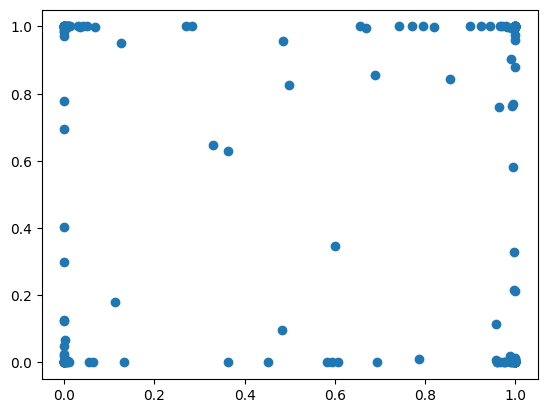

In [4]:
plt.scatter(sigmoid(x3@beta_3).squeeze(),sigmoid(x1@beta_1).squeeze())
sigmoid(x3@beta_3).squeeze().cov()

In [5]:
    # switch training set
    inputs_1,targets_1 = train_x1,train_y1
    inputs_2,targets_2 = train_x2,train_y2
    inputs_3,targets_3 = train_x3,train_y3

    # switching testing set
    test_inputs_1, test_targets_1 = test_x1,test_y1
    test_inputs_2, test_targets_2 = test_x2,test_y2
    test_inputs_3, test_targets_3 = test_x3,test_y3

In [19]:
################## first step##################

# choose lambda1,lambda2 by ray tune

prior=[1,2,3,4,5,11,12,13,14,15]
class MLP(torch.nn.Module):
    def __init__(self,seed):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,1)

    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        out= torch.sigmoid(self.linear3(layer2_out))
        return out, layer1_out, layer2_out
    
def train_model(config):
    split_num=5
    kf = KFold(n_splits=split_num)



    sum_test_BCE_loss=0
    for idx_train,idx_test in kf.split(inputs_1):
        lambda1,lambda2,lr= config["lambda1"], config["lambda2"],config["lr"]
        model_1=MLP(seed=1)
        model_2=MLP(seed=1)
        model_3=MLP(seed=1)
        max_iteration=1000
        learning_rate=lr
        params_to_optimize=list(model_1.parameters())+list(model_2.parameters())+list(model_3.parameters())
        optimizer = torch.optim.SGD(params_to_optimize, lr=learning_rate)
        loss_fn = torch.nn.BCELoss()
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600,700,800], gamma=0.5)

        BCE=[]

        for t in range(max_iteration):
            optimizer.zero_grad() # renew optimizer
            out_1, layer1_out_1, layer2_out_1= model_1(inputs_1[idx_train])
            out_2, layer1_out_2, layer2_out_2= model_2(inputs_2[idx_train])
            out_3, layer1_out_3, layer2_out_3= model_3(inputs_3[idx_train])# forward propagate

            # extract parameters
            #[:-1] for leaving out bias term#
            model_1_all_linear1_params = model_1.linear1
            model_1_all_linear2_params= torch.cat([x.view(-1) for x in model_1.linear2.parameters()][:-1])
            model_1_all_linear3_params= torch.cat([x.view(-1) for x in model_1.linear3.parameters()][:-1])
           

            model_2_all_linear1_params = model_1.linear1
            model_2_all_linear2_params= torch.cat([x.view(-1) for x in model_2.linear2.parameters()][:-1])
            model_2_all_linear3_params= torch.cat([x.view(-1) for x in model_2.linear3.parameters()][:-1])
    

            model_3_all_linear1_params = model_3.linear1
            model_3_all_linear2_params= torch.cat([x.view(-1) for x in model_3.linear2.parameters()][:-1])
            model_3_all_linear3_params= torch.cat([x.view(-1) for x in model_3.linear3.parameters()][:-1])
    


            # compute loss
            all_linear1_params=torch.cat(( model_1_all_linear1_params.reshape(1,-1),  model_2_all_linear1_params.reshape(1,-1), model_3_all_linear1_params.reshape(1,-1)),0)
            all_linear23_params=torch.cat((model_1_all_linear2_params,model_1_all_linear3_params,
                                           model_2_all_linear2_params,model_2_all_linear3_params,
                                           model_3_all_linear2_params,model_3_all_linear3_params),0)
            non_prior=np.setdiff1d([i for i in range(all_linear1_params.shape[1])],prior)

            BCE_loss_1 = loss_fn(out_1, targets_1[idx_train].reshape(-1,1))
            BCE_loss_2 = loss_fn(out_2, targets_2[idx_train].reshape(-1,1))
            BCE_loss_3 = loss_fn(out_3, targets_3[idx_train].reshape(-1,1))

#             l1_regularization = lambda1 * smooth_l1(all_linear1_params,prior)
            l1_regularization = lambda1 * torch.sum(torch.norm(all_linear1_params[:,non_prior],p=2,dim=0))

            l2_regularization = lambda2* torch.sum(all_linear23_params.pow(2))
            BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
            loss =BCE_loss+l1_regularization +l2_regularization

            # record loss
            BCE.append(BCE_loss.item())

            # compute derivative
            loss.backward()

            # gradient descent
            optimizer.step()

            # learning rate decay
            scheduler.step()
        
        
        test_out_1, test_layer1_out_1, test_layer2_out_1= model_1(train_x1[idx_test])
        test_out_2, test_layer1_out_2, test_layer2_out_2= model_2(train_x2[idx_test])
        test_out_3, test_layer1_out_3, test_layer2_out_3= model_3(train_x3[idx_test])
        
        test_BCE_loss_1 = loss_fn(test_out_1, targets_1[idx_test].reshape(-1,1))
        test_BCE_loss_2 = loss_fn(test_out_2, targets_2[idx_test].reshape(-1,1))
        test_BCE_loss_3 = loss_fn(test_out_3, targets_3[idx_test].reshape(-1,1))
        
        test_BCE_loss=test_BCE_loss_1+test_BCE_loss_2+test_BCE_loss_3
        
        sum_test_BCE_loss+=test_BCE_loss.item()

    #print("loss: ",)
    tune.report(my_test_BCE_loss=sum_test_BCE_loss/split_num)
     
        
if __name__ == '__main__':
    inputs_1,targets_1 = train_x1,train_y1
    inputs_2,targets_2 = train_x2,train_y2
    inputs_3,targets_3 = train_x3,train_y3
    #train_model(inputs_1,targets_1,inputs_2,targets_2,inputs_3,targets_3,lambda1=0.1,lambda2=0.06)
    
    config={
        "lr":tune.choice([0.6,0.7,0.8]),
        "lambda1": tune.choice([0.03,0.04,0.05]),
        "lambda2": tune.choice([0.0005,0.001,0.002])
    }
    result = tune.run(
        train_model,  
        config=config,
        num_samples=32)
    
    # 得到最后的结果
    print("======================== Result =========================")
    print(result.results_df)


Trial name,status,loc,lambda1,lambda2,lr,iter,total time (s),my_test_BCE_loss
train_model_15c84_00000,TERMINATED,10.224.0.12:10112,0.04,0.001,0.8,1,28.7555,1.74473
train_model_15c84_00001,TERMINATED,10.224.0.12:10651,0.05,0.002,0.8,1,27.5806,1.56391
train_model_15c84_00002,TERMINATED,10.224.0.12:10654,0.04,0.001,0.8,1,28.1455,1.74473
train_model_15c84_00003,TERMINATED,10.224.0.12:10656,0.05,0.001,0.7,1,27.2888,1.75352
train_model_15c84_00004,TERMINATED,10.224.0.12:10658,0.04,0.0005,0.7,1,27.6806,1.84206
train_model_15c84_00005,TERMINATED,10.224.0.12:10660,0.05,0.002,0.7,1,28.9167,1.53751
train_model_15c84_00006,TERMINATED,10.224.0.12:10661,0.03,0.001,0.8,1,29.0493,1.73501
train_model_15c84_00007,TERMINATED,10.224.0.12:10663,0.05,0.002,0.6,1,26.3651,1.53491
train_model_15c84_00008,TERMINATED,10.224.0.12:10665,0.03,0.002,0.7,1,27.995,1.46599
train_model_15c84_00009,TERMINATED,10.224.0.12:10667,0.04,0.002,0.8,1,23.7516,1.53478


Result for train_model_15c84_00001:
  date: 2022-10-18_09-42-52
  done: false
  experiment_id: abd894d6b8d341f89ec2d43aa0614445
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.5639092683792115
  node_ip: 10.224.0.12
  pid: 10651
  time_since_restore: 27.58060622215271
  time_this_iter_s: 27.58060622215271
  time_total_s: 27.58060622215271
  timestamp: 1666057372
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 15c84_00001
  warmup_time: 0.03259897232055664
  
Result for train_model_15c84_00019:
  date: 2022-10-18_09-42-52
  done: false
  experiment_id: 4bf206d4e92c4df0bf35ce2d7eceab03
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.8040608644485474
  node_ip: 10.224.0.12
  pid: 10688
  time_since_restore: 26.666434288024902
  time_this_iter_s: 26.666434288024902
  time_total_s: 26.666434288024902
  timestamp: 1666057372
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 15c84_00019
  w

Result for train_model_15c84_00021:
  date: 2022-10-18_09-42-52
  done: false
  experiment_id: db4f937fb6b44a359160e370ceb916ce
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.718259072303772
  node_ip: 10.224.0.12
  pid: 10691
  time_since_restore: 26.08557939529419
  time_this_iter_s: 26.08557939529419
  time_total_s: 26.08557939529419
  timestamp: 1666057372
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 15c84_00021
  warmup_time: 0.025342226028442383
  
Result for train_model_15c84_00017:
  date: 2022-10-18_09-42-51
  done: true
  experiment_id: fc23c3d75e844bbfb28fe2690afa6ce0
  experiment_tag: 17_lambda1=0.0500,lambda2=0.0005,lr=0.7000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.8732059001922607
  node_ip: 10.224.0.12
  pid: 10683
  time_since_restore: 26.802422523498535
  time_this_iter_s: 26.802422523498535
  time_total_s: 26.802422523498535
  timestamp: 1666057371
  timesteps_since_re

Result for train_model_15c84_00020:
  date: 2022-10-18_09-42-50
  done: false
  experiment_id: 0ce7d37cc3ba483a97f2932529792f8b
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.5349136114120483
  node_ip: 10.224.0.12
  pid: 10689
  time_since_restore: 25.45606017112732
  time_this_iter_s: 25.45606017112732
  time_total_s: 25.45606017112732
  timestamp: 1666057370
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 15c84_00020
  warmup_time: 0.01639413833618164
  
Result for train_model_15c84_00008:
  date: 2022-10-18_09-42-53
  done: true
  experiment_id: dda0a5cd74564e2d85692dcc884b42eb
  experiment_tag: 8_lambda1=0.0300,lambda2=0.0020,lr=0.7000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.4659860134124756
  node_ip: 10.224.0.12
  pid: 10665
  time_since_restore: 27.99501895904541
  time_this_iter_s: 27.99501895904541
  time_total_s: 27.99501895904541
  timestamp: 1666057373
  timesteps_since_restor

Result for train_model_15c84_00028:
  date: 2022-10-18_09-43-10
  done: false
  experiment_id: b1b6b039b99745a194797040892f93d0
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.9448919534683227
  node_ip: 10.224.0.12
  pid: 11543
  time_since_restore: 16.033058643341064
  time_this_iter_s: 16.033058643341064
  time_total_s: 16.033058643341064
  timestamp: 1666057390
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 15c84_00028
  warmup_time: 0.009268760681152344
  
Result for train_model_15c84_00028:
  date: 2022-10-18_09-43-10
  done: true
  experiment_id: b1b6b039b99745a194797040892f93d0
  experiment_tag: 28_lambda1=0.0500,lambda2=0.0005,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.9448919534683227
  node_ip: 10.224.0.12
  pid: 11543
  time_since_restore: 16.033058643341064
  time_this_iter_s: 16.033058643341064
  time_total_s: 16.033058643341064
  timestamp: 1666057390
  timesteps_sinc

2022-10-18 09:43:21,722	INFO tune.py:758 -- Total run time: 70.10 seconds (69.94 seconds for the tuning loop).


======================== Result =========================
             my_test_BCE_loss  time_this_iter_s  done timesteps_total  \
trial_id                                                                
15c84_00000          1.744728         28.755527  True            None   
15c84_00001          1.563909         27.580606  True            None   
15c84_00002          1.744728         28.145454  True            None   
15c84_00003          1.753522         27.288792  True            None   
15c84_00004          1.842064         27.680591  True            None   
15c84_00005          1.537508         28.916650  True            None   
15c84_00006          1.735010         29.049266  True            None   
15c84_00007          1.534914         26.365145  True            None   
15c84_00008          1.465986         27.995019  True            None   
15c84_00009          1.534778         23.751561  True            None   
15c84_00010          1.744728         23.837324  True            N

In [20]:
best_trial = result.get_best_trial("my_test_BCE_loss", "min", "last")
print("Best trial final validation loss: {}".format(best_trial.last_result["my_test_BCE_loss"]))
final_lambda=result.get_best_config('my_test_BCE_loss',mode='min')
final_lambda

Best trial final validation loss: 1.4659860134124756


{'lr': 0.7, 'lambda1': 0.03, 'lambda2': 0.002}

In [38]:
################## second step##################

#0.4,0.4
# set hyperparamters

prior=[1,2,3,4,5,11,12,13,14,15]
final_lambda=result.get_best_config('my_test_BCE_loss',mode='min')
lambda1,lambda2,lr=final_lambda["lambda1"],final_lambda["lambda2"],final_lambda["lr"]
learning_rate=lr
max_iteration=1000

# switch training set
inputs_1,targets_1 = train_x1,train_y1
inputs_2,targets_2 = train_x2,train_y2
inputs_3,targets_3 = train_x3,train_y3

# switching testing set
test_inputs_1, test_targets_1 = test_x1,test_y1
test_inputs_2, test_targets_2 = test_x2,test_y2
test_inputs_3, test_targets_3 = test_x3,test_y3

# record loss descent
BCE=[]


# main nn object
class MLP(torch.nn.Module):
    def __init__(self,seed):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,1)

    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        out= torch.sigmoid(self.linear3(layer2_out))
        return out, layer1_out, layer2_out


model_1=MLP(seed=1)
model_2=MLP(seed=1)
model_3=MLP(seed=1)

loss_fn = torch.nn.BCELoss()
params_to_optimize=list(model_1.parameters())+list(model_2.parameters())+list(model_3.parameters())
optimizer = torch.optim.SGD(params_to_optimize, lr=learning_rate)

# learning rate decay scheme
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600,700,800], gamma=0.6)

loss_record=[]
# loop for max_iteration times
for t in range(max_iteration):
    
    # renew optimizer
    optimizer.zero_grad()
    
    # forward propagate
    out_1, layer1_out_1, layer2_out_1= model_1(inputs_1)
    out_2, layer1_out_2, layer2_out_2= model_2(inputs_2)
    out_3, layer1_out_3, layer2_out_3= model_3(inputs_3)
    
    
    
    # extract parameters
    #[:-1] for leaving out bias term#
    model_1_all_linear1_params = model_1.linear1
    model_1_all_linear2_params= torch.cat([x.view(-1) for x in model_1.linear2.parameters()][:-1])
    model_1_all_linear3_params= torch.cat([x.view(-1) for x in model_1.linear3.parameters()][:-1])

    
    model_2_all_linear1_params = model_1.linear1
    model_2_all_linear2_params= torch.cat([x.view(-1) for x in model_2.linear2.parameters()][:-1])
    model_2_all_linear3_params= torch.cat([x.view(-1) for x in model_2.linear3.parameters()][:-1])

    
    model_3_all_linear1_params = model_3.linear1
    model_3_all_linear2_params= torch.cat([x.view(-1) for x in model_3.linear2.parameters()][:-1])
    model_3_all_linear3_params= torch.cat([x.view(-1) for x in model_3.linear3.parameters()][:-1])
    

    # compute loss

    all_linear1_params=torch.cat(( model_1_all_linear1_params.reshape(1,-1),  model_2_all_linear1_params.reshape(1,-1), model_3_all_linear1_params.reshape(1,-1)),0)
    all_linear23_params=torch.cat((model_1_all_linear2_params,model_1_all_linear3_params, 
                                     model_2_all_linear2_params,model_2_all_linear3_params,
                                     model_3_all_linear2_params,model_3_all_linear3_params),0)
    non_prior=np.setdiff1d([i for i in range(all_linear1_params.shape[1])],prior)
    
    BCE_loss_1 = loss_fn(out_1, targets_1.reshape(-1,1))
    BCE_loss_2 = loss_fn(out_2, targets_2.reshape(-1,1))
    BCE_loss_3 = loss_fn(out_3, targets_3.reshape(-1,1))
    
#     l1_regularization = lambda1 * smooth_l1(all_linear1_params,prior)
    
    l1_regularization = lambda1 * torch.sum(torch.norm(all_linear1_params[:,non_prior],p=2,dim=0))
    
    l2_regularization = lambda2 * torch.sum(all_linear23_params.pow(2))
    BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
    loss =BCE_loss+l1_regularization +l2_regularization
    
    loss_record.append(loss.item())
    # record loss
    BCE.append(BCE_loss.item())
    
    # compute derivative
    loss.backward()
    
    # gradient descent
    optimizer.step()
    
    # learning rate decay
    scheduler.step()


tensor(0.2063, grad_fn=<AddBackward0>)

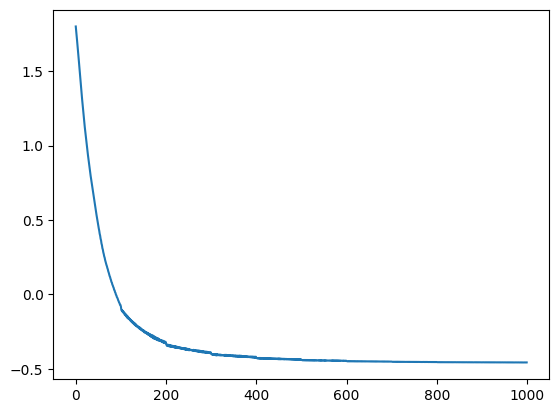

In [39]:
BCE_loss
plt.plot([math.log(x) for x in loss_record])

In [40]:
################## Y_prior##################

y_prior_1= (model_1(train_x1)[0]).detach().squeeze()

y_prior_2= (model_2(train_x2)[0]).detach().squeeze()

y_prior_3= (model_3(train_x3)[0]).detach().squeeze()

BCE_loss_1 = loss_fn(y_prior_1,train_y1)
BCE_loss_2 = loss_fn(y_prior_2, train_y2)
BCE_loss_3 = loss_fn(y_prior_3, train_y3)
BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
BCE_loss
BCE_loss_1
BCE_loss_2
BCE_loss_3

tensor(0.2063)

tensor(0.0930)

tensor(0.0068)

tensor(0.1064)

In [41]:
y_p_1= (model_1(train_x1)[0]>0.5).clone().int()
t_p_1= train_y1.reshape(-1,1).int()

y_p_2= (model_2(train_x2)[0]>0.5).clone().int()
t_p_2= train_y2.reshape(-1,1).int()

y_p_3= (model_3(train_x3)[0]>0.5).clone().int()
t_p_3= train_y3.reshape(-1,1).int()

confusion_matrix(t_p_1,y_p_1)
confusion_matrix(t_p_2,y_p_2)
confusion_matrix(t_p_3,y_p_3)

array([[79,  1],
       [ 1, 79]])

array([[79,  0],
       [ 0, 81]])

array([[75,  2],
       [ 1, 82]])

(raylet) [2022-10-18 09:50:21,666 E 30325 30347] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-18_09-36-06_804259_25452 is over 95% full, available space: 1469730816; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-18 09:50:31,674 E 30325 30347] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-18_09-36-06_804259_25452 is over 95% full, available space: 1468772352; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-18 09:50:41,682 E 30325 30347] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-18_09-36-06_804259_25452 is over 95% full, available space: 1467764736; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-18 09:50:51,700 E 30325 30347] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-18_09-36-06_804259_25452 is over 95% full, available space: 1466712064; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-18 09:55:31,969 E 30325 30347] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-18_09-36-06_804259_25452 is over 95% full, available space: 1448861696; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-18 09:55:41,976 E 30325 30347] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-18_09-36-06_804259_25452 is over 95% full, available space: 1448673280; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-18 09:55:51,984 E 30325 30347] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-18_09-36-06_804259_25452 is over 95% full, available space: 1448615936; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-18 09:56:01,991 E 30325 30347] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-18_09-36-06_804259_25452 is over 95% full, available space: 1448349696; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-18 10:00:42,209 E 30325 30347] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-18_09-36-06_804259_25452 is over 95% full, available space: 1443934208; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-18 10:00:52,217 E 30325 30347] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-18_09-36-06_804259_25452 is over 95% full, available space: 1443864576; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-18 10:01:02,225 E 30325 30347] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-18_09-36-06_804259_25452 is over 95% full, available space: 1443762176; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-18 10:01:12,234 E 30325 30347] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-18_09-36-06_804259_25452 is over 95% full, available space: 1443622912; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-18 10:05:52,458 E 30325 30347] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-18_09-36-06_804259_25452 is over 95% full, available space: 1440698368; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-18 10:06:02,466 E 30325 30347] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-18_09-36-06_804259_25452 is over 95% full, available space: 1440600064; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-18 10:06:12,473 E 30325 30347] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-18_09-36-06_804259_25452 is over 95% full, available space: 1440481280; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-18 10:06:22,482 E 30325 30347] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-18_09-36-06_804259_25452 is over 95% full, available space: 1440378880; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-18 10:11:02,789 E 30325 30347] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-18_09-36-06_804259_25452 is over 95% full, available space: 1423650816; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-18 10:11:12,799 E 30325 30347] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-18_09-36-06_804259_25452 is over 95% full, available space: 1422897152; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-18 10:11:22,808 E 30325 30347] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-18_09-36-06_804259_25452 is over 95% full, available space: 1421950976; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-18 10:11:32,818 E 30325 30347] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-18_09-36-06_804259_25452 is over 95% full, available space: 1420414976; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-18 10:16:13,199 E 30325 30347] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-18_09-36-06_804259_25452 is over 95% full, available space: 1393930240; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-18 10:16:23,250 E 30325 30347] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-18_09-36-06_804259_25452 is over 95% full, available space: 1392549888; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-18 10:16:33,263 E 30325 30347] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-18_09-36-06_804259_25452 is over 95% full, available space: 1392250880; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-18 10:16:43,273 E 30325 30347] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-18_09-36-06_804259_25452 is over 95% full, available space: 1391038464; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-18 10:21:23,631 E 30325 30347] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-18_09-36-06_804259_25452 is over 95% full, available space: 1362960384; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-18 10:21:33,639 E 30325 30347] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-18_09-36-06_804259_25452 is over 95% full, available space: 1362026496; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-18 10:21:43,652 E 30325 30347] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-18_09-36-06_804259_25452 is over 95% full, available space: 1361051648; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-18 10:21:53,663 E 30325 30347] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-18_09-36-06_804259_25452 is over 95% full, available space: 1360322560; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-18 10:26:34,006 E 30325 30347] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-18_09-36-06_804259_25452 is over 95% full, available space: 1333698560; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-18 10:26:44,014 E 30325 30347] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-18_09-36-06_804259_25452 is over 95% full, available space: 1332645888; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-18 10:26:54,022 E 30325 30347] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-18_09-36-06_804259_25452 is over 95% full, available space: 1331449856; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-18 10:27:04,030 E 30325 30347] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-18_09-36-06_804259_25452 is over 95% full, available space: 1330769920; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-18 10:31:44,333 E 30325 30347] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-18_09-36-06_804259_25452 is over 95% full, available space: 1315287040; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-18 10:31:54,341 E 30325 30347] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-18_09-36-06_804259_25452 is over 95% full, available space: 1315229696; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-18 10:32:04,349 E 30325 30347] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-18_09-36-06_804259_25452 is over 95% full, available space: 1315168256; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-18 10:32:14,358 E 30325 30347] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-18_09-36-06_804259_25452 is over 95% full, available space: 1315061760; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-18 10:36:54,588 E 30325 30347] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-18_09-36-06_804259_25452 is over 95% full, available space: 1305866240; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-18 10:37:04,600 E 30325 30347] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-18_09-36-06_804259_25452 is over 95% full, available space: 1306116096; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-18 10:37:14,605 E 30325 30347] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-18_09-36-06_804259_25452 is over 95% full, available space: 1304662016; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-18 10:37:24,612 E 30325 30347] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-18_09-36-06_804259_25452 is over 95% full, available space: 1304248320; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-18 10:42:04,835 E 30325 30347] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-18_09-36-06_804259_25452 is over 95% full, available space: 1292148736; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-18 10:42:14,842 E 30325 30347] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-18_09-36-06_804259_25452 is over 95% full, available space: 1292046336; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-18 10:42:24,850 E 30325 30347] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-18_09-36-06_804259_25452 is over 95% full, available space: 1291927552; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-18 10:42:34,858 E 30325 30347] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-18_09-36-06_804259_25452 is over 95% full, available space: 1291816960; capacity: 29394726912. Object creation will fa

In [12]:
################## third step##################

#no prior
prior=0
# switching testing set
test_inputs_1, test_targets_1 = test_x1,test_y1
test_inputs_2, test_targets_2 = test_x2,test_y2
test_inputs_3, test_targets_3 = test_x3,test_y3



# choose lambda1,lambda2 by ray tune
class MLP(torch.nn.Module):
    def __init__(self,seed):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,10)
        self.linear4 = torch.nn.Linear(10,1)
    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        layer3_out = F.relu(self.linear3(layer2_out))
        out= torch.sigmoid(self.linear4(layer3_out))
        return out, layer1_out, layer2_out,layer3_out
    
def train_model(config):
    split_num=5
    kf = KFold(n_splits=split_num)
    
    
    lambda1,lambda2,eta,lr= config["lambda1"], config["lambda2"],config["eta"],config["lr"]
    inputs_1,inputs_2,inputs_3=train_x1,train_x2,train_x3
    targets_1=(1-eta)*train_y1+eta*y_prior_1
    targets_2=(1-eta)*train_y2+eta*y_prior_2
    targets_3=(1-eta)*train_y3+eta*y_prior_3
    
    
    sum_tGM=0
    sum_test_BCE_loss=0
    for idx_train,idx_test in kf.split(inputs_1):
       
        
        model_1=MLP(seed=1)
        model_2=MLP(seed=1)
        model_3=MLP(seed=1)
        max_iteration=1000
        learning_rate=lr
        params_to_optimize=list(model_1.parameters())+list(model_2.parameters())+list(model_3.parameters())
        optimizer = torch.optim.SGD(params_to_optimize, lr=learning_rate)
        loss_fn = torch.nn.BCELoss()
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600,700,800], gamma=0.3)

        BCE=[]

        for t in range(max_iteration):
            optimizer.zero_grad() # renew optimizer
            out_1, layer1_out_1, layer2_out_1,layer3_out_1= model_1(inputs_1[idx_train])
            out_2, layer1_out_2, layer2_out_2,layer3_out_2= model_2(inputs_2[idx_train])
            out_3, layer1_out_3, layer2_out_3,layer3_out_3= model_3(inputs_3[idx_train])# forward propagate

            # extract parameters
            #[:-1] for leaving out bias term#
            model_1_all_linear1_params = model_1.linear1
            model_1_all_linear2_params= torch.cat([x.view(-1) for x in model_1.linear2.parameters()][:-1])
            model_1_all_linear3_params= torch.cat([x.view(-1) for x in model_1.linear3.parameters()][:-1])
            model_1_all_linear4_params= torch.cat([x.view(-1) for x in model_1.linear4.parameters()][:-1])
           

            model_2_all_linear1_params = model_1.linear1
            model_2_all_linear2_params= torch.cat([x.view(-1) for x in model_2.linear2.parameters()][:-1])
            model_2_all_linear3_params= torch.cat([x.view(-1) for x in model_2.linear3.parameters()][:-1])
            model_2_all_linear4_params= torch.cat([x.view(-1) for x in model_2.linear4.parameters()][:-1])
    

            model_3_all_linear1_params = model_3.linear1
            model_3_all_linear2_params= torch.cat([x.view(-1) for x in model_3.linear2.parameters()][:-1])
            model_3_all_linear3_params= torch.cat([x.view(-1) for x in model_3.linear3.parameters()][:-1])
            model_3_all_linear4_params= torch.cat([x.view(-1) for x in model_3.linear4.parameters()][:-1])
    


            # compute loss
            all_linear1_params=torch.cat(( model_1_all_linear1_params.reshape(1,-1),  model_2_all_linear1_params.reshape(1,-1), model_3_all_linear1_params.reshape(1,-1)),0)
            all_linear234_params=torch.cat((model_1_all_linear2_params,model_1_all_linear3_params, model_1_all_linear4_params,
                                             model_2_all_linear2_params,model_2_all_linear3_params, model_2_all_linear4_params,
                                             model_3_all_linear2_params,model_3_all_linear3_params,model_3_all_linear4_params),0)

            BCE_loss_1 = loss_fn(out_1, targets_1[idx_train].reshape(-1,1))
            BCE_loss_2 = loss_fn(out_2, targets_2[idx_train].reshape(-1,1))
            BCE_loss_3 = loss_fn(out_3, targets_3[idx_train].reshape(-1,1))

#             l1_regularization = lambda1 * smooth_l1(all_linear1_params,prior)
            l1_regularization = lambda1 * torch.sum(torch.norm(all_linear1_params[:,prior:],p=2,dim=0))

            l2_regularization = lambda2* torch.sum(all_linear234_params.pow(2))
            BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
            loss =BCE_loss+l1_regularization +l2_regularization

            # record loss
            BCE.append(BCE_loss.item())

            # compute derivative
            loss.backward()

            # gradient descent
            optimizer.step()

            # learning rate decay
            scheduler.step()
        
        
        test_out_1, test_layer1_out_1, test_layer2_out_1,test_layer3_out_1= model_1(train_x1[idx_test])
        test_out_2, test_layer1_out_2, test_layer2_out_2,test_layer3_out_2= model_2(train_x2[idx_test])
        test_out_3, test_layer1_out_3, test_layer2_out_3,test_layer3_out_3= model_3(train_x3[idx_test])
        
# #         test_BCE_loss_1 = loss_fn(test_out_1, targets_1[idx_test].reshape(-1,1))
# #         test_BCE_loss_2 = loss_fn(test_out_2, targets_2[idx_test].reshape(-1,1))
# #         test_BCE_loss_3 = loss_fn(test_out_3, targets_3[idx_test].reshape(-1,1))

#         test_BCE_loss_1 = loss_fn(test_out_1, train_y1[idx_test].reshape(-1,1))
#         test_BCE_loss_2 = loss_fn(test_out_2, train_y2[idx_test].reshape(-1,1))
#         test_BCE_loss_3 = loss_fn(test_out_3, train_y3[idx_test].reshape(-1,1))
        
#         test_BCE_loss=test_BCE_loss_1+test_BCE_loss_2+test_BCE_loss_3
        
#         sum_test_BCE_loss+=test_BCE_loss.item()

#     #print("loss: ",)
#     tune.report(my_test_BCE_loss=sum_test_BCE_loss/split_num)

        test_prediction_1= (model_1(train_x1[idx_test])[0]>0.5).clone().int()
        test_target_1= train_y1[idx_test].reshape(-1,1).int()

        test_prediction_2= (model_2(train_x2[idx_test])[0]>0.5).clone().int()
        test_target_2= train_y2[idx_test].reshape(-1,1).int()

        test_prediction_3= (model_3(train_x3[idx_test])[0]>0.5).clone().int()
        test_target_3= train_y3[idx_test].reshape(-1,1).int()

        test_prediction=np.append(test_prediction_1,test_prediction_2)
        test_prediction=np.append(test_prediction,test_prediction_3)
        test_prediction=test_prediction.tolist()

        test_target=np.append(test_target_1,test_target_2)
        test_target=np.append(test_target,test_target_3)
        test_target=test_target.tolist()

        final_matrix=confusion_matrix(test_target,test_prediction)
        tTPR=recall_score(test_target,test_target)#TPR
        tTNR=final_matrix[0,0]/(sum(final_matrix[0,:]))#TNR
        tGM=math.sqrt(tTPR*tTNR)

        sum_tGM+=tGM

    tune.report(my_test_sum_tGM=sum_tGM/split_num)
     
        
if __name__ == '__main__':
#     inputs_1,targets_1 = train_x1,train_y1
#     inputs_2,targets_2 = train_x2,train_y2
#     inputs_3,targets_3 = train_x3,train_y3
    #train_model(inputs_1,targets_1,inputs_2,targets_2,inputs_3,targets_3,lambda1=0.1,lambda2=0.06)
    
#     config={
#         "lambda1": tune.choice([0.01,0.02,0.03,0.04,0.05]),
#         "lambda2": tune.choice([0.001,0.002,0.003]),
#         "eta": tune.choice([0.06,0.09,0.1,0.12,0.15,0.17,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95])
#     }
    config={
        "lambda1": tune.choice([0.03,0.04,0.05]),
        "lambda2": tune.choice([0.002,0.003]),
         "eta": tune.choice([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]),
         "lr":tune.choice([0.6,0.7,0.8])
                            }
#         "eta": tune.choice([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])



    result = tune.run(
        train_model,  
        config=config,
        num_samples=220)
    
    # 得到最后的结果
    print("======================== Result =========================")
    print(result.results_df)


Trial name,status,loc,eta,lambda1,lambda2,lr,iter,total time (s),my_test_sum_tGM
train_model_6fce5_00000,TERMINATED,10.224.0.12:853,0.1,0.04,0.002,0.8,1,23.8802,0.902538
train_model_6fce5_00001,TERMINATED,10.224.0.12:1322,0.8,0.05,0.002,0.6,1,28.1013,0.907154
train_model_6fce5_00002,TERMINATED,10.224.0.12:1324,0.3,0.04,0.003,0.8,1,28.2777,0.901732
train_model_6fce5_00003,TERMINATED,10.224.0.12:1326,0.7,0.03,0.002,0.8,1,29.0733,0.882334
train_model_6fce5_00004,TERMINATED,10.224.0.12:1328,0.5,0.04,0.003,0.7,1,29.0491,0.902205
train_model_6fce5_00005,TERMINATED,10.224.0.12:1332,0.7,0.04,0.003,0.6,1,23.4147,0.875973
train_model_6fce5_00006,TERMINATED,10.224.0.12:1334,0.2,0.05,0.002,0.8,1,23.7452,0.902205
train_model_6fce5_00007,TERMINATED,10.224.0.12:1336,0.3,0.05,0.002,0.6,1,29.7131,0.902265
train_model_6fce5_00008,TERMINATED,10.224.0.12:1338,0.4,0.05,0.003,0.6,1,29.7721,0.897358
train_model_6fce5_00009,TERMINATED,10.224.0.12:1340,0.8,0.04,0.003,0.8,1,28.5815,0.894762


Result for train_model_6fce5_00000:
  date: 2022-10-18_09-37-59
  done: false
  experiment_id: 75d1dcd337df435d97665d600984833a
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9025379647471491
  node_ip: 10.224.0.12
  pid: 853
  time_since_restore: 23.88021492958069
  time_this_iter_s: 23.88021492958069
  time_total_s: 23.88021492958069
  timestamp: 1666057079
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 6fce5_00000
  warmup_time: 0.003025531768798828
  
Result for train_model_6fce5_00000:
  date: 2022-10-18_09-37-59
  done: true
  experiment_id: 75d1dcd337df435d97665d600984833a
  experiment_tag: 0_eta=0.1000,lambda1=0.0400,lambda2=0.0020,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9025379647471491
  node_ip: 10.224.0.12
  pid: 853
  time_since_restore: 23.88021492958069
  time_this_iter_s: 23.88021492958069
  time_total_s: 23.88021492958069
  timestamp: 1666057079
  timesteps_since_

Result for train_model_6fce5_00024:
  date: 2022-10-18_09-38-04
  done: true
  experiment_id: bc8ca83ee88f424687fc2be5e065fdad
  experiment_tag: 24_eta=0.3000,lambda1=0.0300,lambda2=0.0030,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.872854402645164
  node_ip: 10.224.0.12
  pid: 1371
  time_since_restore: 24.503497838974
  time_this_iter_s: 24.503497838974
  time_total_s: 24.503497838974
  timestamp: 1666057084
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 6fce5_00024
  warmup_time: 0.011698484420776367
  
Result for train_model_6fce5_00023:
  date: 2022-10-18_09-38-05
  done: false
  experiment_id: 799f8d6fac3144e29f42747dff72d7e6
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8603222971001034
  node_ip: 10.224.0.12
  pid: 1369
  time_since_restore: 24.653311252593994
  time_this_iter_s: 24.653311252593994
  time_total_s: 24.653311252593994
  timestamp: 1666057085
  timesteps_since_r

Result for train_model_6fce5_00031:
  date: 2022-10-18_09-38-07
  done: false
  experiment_id: de5b2fb01fb547c6bc8ac919004ab9a2
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8943470110217383
  node_ip: 10.224.0.12
  pid: 1385
  time_since_restore: 26.70292592048645
  time_this_iter_s: 26.70292592048645
  time_total_s: 26.70292592048645
  timestamp: 1666057087
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 6fce5_00031
  warmup_time: 0.00832819938659668
  
Result for train_model_6fce5_00031:
  date: 2022-10-18_09-38-07
  done: true
  experiment_id: de5b2fb01fb547c6bc8ac919004ab9a2
  experiment_tag: 31_eta=0.5000,lambda1=0.0400,lambda2=0.0020,lr=0.7000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8943470110217383
  node_ip: 10.224.0.12
  pid: 1385
  time_since_restore: 26.70292592048645
  time_this_iter_s: 26.70292592048645
  time_total_s: 26.70292592048645
  timestamp: 1666057087
  timesteps_sinc

Result for train_model_6fce5_00009:
  date: 2022-10-18_09-38-09
  done: true
  experiment_id: bc29496f354c452eb896b7f3c7f731b0
  experiment_tag: 9_eta=0.8000,lambda1=0.0400,lambda2=0.0030,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8947615963072856
  node_ip: 10.224.0.12
  pid: 1340
  time_since_restore: 28.581499099731445
  time_this_iter_s: 28.581499099731445
  time_total_s: 28.581499099731445
  timestamp: 1666057089
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 6fce5_00009
  warmup_time: 0.006824016571044922
  
Result for train_model_6fce5_00004:
  date: 2022-10-18_09-38-09
  done: false
  experiment_id: 7e059b45a3b14189bbc18afcd6b91921
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9022052864408565
  node_ip: 10.224.0.12
  pid: 1328
  time_since_restore: 29.049143314361572
  time_this_iter_s: 29.049143314361572
  time_total_s: 29.049143314361572
  timestamp: 1666057089
  timestep

Result for train_model_6fce5_00026:
  date: 2022-10-18_09-38-14
  done: false
  experiment_id: 24c593c3d601460f9425dfbf7968a1ea
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.860478422436266
  node_ip: 10.224.0.12
  pid: 1380
  time_since_restore: 33.175318002700806
  time_this_iter_s: 33.175318002700806
  time_total_s: 33.175318002700806
  timestamp: 1666057094
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 6fce5_00026
  warmup_time: 0.00559544563293457
  
Result for train_model_6fce5_00026:
  date: 2022-10-18_09-38-14
  done: true
  experiment_id: 24c593c3d601460f9425dfbf7968a1ea
  experiment_tag: 26_eta=0.5000,lambda1=0.0300,lambda2=0.0020,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.860478422436266
  node_ip: 10.224.0.12
  pid: 1380
  time_since_restore: 33.175318002700806
  time_this_iter_s: 33.175318002700806
  time_total_s: 33.175318002700806
  timestamp: 1666057094
  timesteps_

Result for train_model_6fce5_00033:
  date: 2022-10-18_09-38-27
  done: false
  experiment_id: e11db395023e44f08308f8f861dc242d
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8603222971001034
  node_ip: 10.224.0.12
  pid: 1359
  time_since_restore: 24.227198600769043
  time_this_iter_s: 24.227198600769043
  time_total_s: 24.227198600769043
  timestamp: 1666057107
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 6fce5_00033
  warmup_time: 0.0034720897674560547
  
Result for train_model_6fce5_00033:
  date: 2022-10-18_09-38-27
  done: true
  experiment_id: e11db395023e44f08308f8f861dc242d
  experiment_tag: 33_eta=0.6000,lambda1=0.0300,lambda2=0.0020,lr=0.7000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8603222971001034
  node_ip: 10.224.0.12
  pid: 1359
  time_since_restore: 24.227198600769043
  time_this_iter_s: 24.227198600769043
  time_total_s: 24.227198600769043
  timestamp: 1666057107
  timest

Result for train_model_6fce5_00050:
  date: 2022-10-18_09-38-29
  done: false
  experiment_id: 5f4ba3e6841943f9bea69c654fe9b858
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9045372601120821
  node_ip: 10.224.0.12
  pid: 1342
  time_since_restore: 21.00708293914795
  time_this_iter_s: 21.00708293914795
  time_total_s: 21.00708293914795
  timestamp: 1666057109
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 6fce5_00050
  warmup_time: 0.007132053375244141
  
Result for train_model_6fce5_00050:
  date: 2022-10-18_09-38-29
  done: true
  experiment_id: 5f4ba3e6841943f9bea69c654fe9b858
  experiment_tag: 50_eta=0.7000,lambda1=0.0500,lambda2=0.0030,lr=0.7000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9045372601120821
  node_ip: 10.224.0.12
  pid: 1342
  time_since_restore: 21.00708293914795
  time_this_iter_s: 21.00708293914795
  time_total_s: 21.00708293914795
  timestamp: 1666057109
  timesteps_sin

Result for train_model_6fce5_00048:
  date: 2022-10-18_09-38-30
  done: false
  experiment_id: 4f56b4a91f0c4c6bbe2ba738ac90ccbe
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.857685955601692
  node_ip: 10.224.0.12
  pid: 1322
  time_since_restore: 22.780981302261353
  time_this_iter_s: 22.780981302261353
  time_total_s: 22.780981302261353
  timestamp: 1666057110
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 6fce5_00048
  warmup_time: 0.006873369216918945
  
Result for train_model_6fce5_00048:
  date: 2022-10-18_09-38-30
  done: true
  experiment_id: 4f56b4a91f0c4c6bbe2ba738ac90ccbe
  experiment_tag: 48_eta=0.4000,lambda1=0.0300,lambda2=0.0020,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.857685955601692
  node_ip: 10.224.0.12
  pid: 1322
  time_since_restore: 22.780981302261353
  time_this_iter_s: 22.780981302261353
  time_total_s: 22.780981302261353
  timestamp: 1666057110
  timesteps

Result for train_model_6fce5_00063:
  date: 2022-10-18_09-38-33
  done: true
  experiment_id: 24c593c3d601460f9425dfbf7968a1ea
  experiment_tag: 63_eta=0.8000,lambda1=0.0400,lambda2=0.0030,lr=0.7000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8977732546949679
  node_ip: 10.224.0.12
  pid: 1380
  time_since_restore: 18.94705295562744
  time_this_iter_s: 18.94705295562744
  time_total_s: 18.94705295562744
  timestamp: 1666057113
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 6fce5_00063
  warmup_time: 0.00559544563293457
  
Result for train_model_6fce5_00064:
  date: 2022-10-18_09-38-40
  done: false
  experiment_id: 75d1dcd337df435d97665d600984833a
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8812563496233988
  node_ip: 10.224.0.12
  pid: 853
  time_since_restore: 17.069751977920532
  time_this_iter_s: 17.069751977920532
  time_total_s: 17.069751977920532
  timestamp: 1666057120
  timesteps_si

Result for train_model_6fce5_00075:
  date: 2022-10-18_09-38-44
  done: false
  experiment_id: 8bd59d69538640af8083f9b09fdaa7d2
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8973579725581289
  node_ip: 10.224.0.12
  pid: 1353
  time_since_restore: 16.87343692779541
  time_this_iter_s: 16.87343692779541
  time_total_s: 16.87343692779541
  timestamp: 1666057124
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 6fce5_00075
  warmup_time: 0.005176067352294922
  
Result for train_model_6fce5_00075:
  date: 2022-10-18_09-38-44
  done: true
  experiment_id: 8bd59d69538640af8083f9b09fdaa7d2
  experiment_tag: 75_eta=0.4000,lambda1=0.0500,lambda2=0.0030,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8973579725581289
  node_ip: 10.224.0.12
  pid: 1353
  time_since_restore: 16.87343692779541
  time_this_iter_s: 16.87343692779541
  time_total_s: 16.87343692779541
  timestamp: 1666057124
  timesteps_sin

Result for train_model_6fce5_00082:
  date: 2022-10-18_09-38-46
  done: false
  experiment_id: 59c7750f50534b4888c9d13cbfeea024
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8659845513770836
  node_ip: 10.224.0.12
  pid: 1355
  time_since_restore: 17.279165744781494
  time_this_iter_s: 17.279165744781494
  time_total_s: 17.279165744781494
  timestamp: 1666057126
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 6fce5_00082
  warmup_time: 0.006351470947265625
  
Result for train_model_6fce5_00079:
  date: 2022-10-18_09-38-46
  done: false
  experiment_id: 0b1a3db760824cc9bc1ffc55d9bf8deb
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9017320444387803
  node_ip: 10.224.0.12
  pid: 1326
  time_since_restore: 17.7210476398468
  time_this_iter_s: 17.7210476398468
  time_total_s: 17.7210476398468
  timestamp: 1666057126
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 6fce5_00079
  warmup_

Result for train_model_6fce5_00085:
  date: 2022-10-18_09-38-50
  done: false
  experiment_id: 7e059b45a3b14189bbc18afcd6b91921
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8717324362644927
  node_ip: 10.224.0.12
  pid: 1328
  time_since_restore: 19.853503704071045
  time_this_iter_s: 19.853503704071045
  time_total_s: 19.853503704071045
  timestamp: 1666057130
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 6fce5_00085
  warmup_time: 0.007604122161865234
  
Result for train_model_6fce5_00085:
  date: 2022-10-18_09-38-50
  done: true
  experiment_id: 7e059b45a3b14189bbc18afcd6b91921
  experiment_tag: 85_eta=0.5000,lambda1=0.0300,lambda2=0.0020,lr=0.7000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8717324362644927
  node_ip: 10.224.0.12
  pid: 1328
  time_since_restore: 19.853503704071045
  time_this_iter_s: 19.853503704071045
  time_total_s: 19.853503704071045
  timestamp: 1666057130
  timeste

Result for train_model_6fce5_00094:
  date: 2022-10-18_09-38-54
  done: true
  experiment_id: 23a3e15323e34832b7ae704c13b94516
  experiment_tag: 94_eta=0.1000,lambda1=0.0300,lambda2=0.0020,lr=0.7000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8626015566850335
  node_ip: 10.224.0.12
  pid: 1351
  time_since_restore: 21.26012945175171
  time_this_iter_s: 21.26012945175171
  time_total_s: 21.26012945175171
  timestamp: 1666057134
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 6fce5_00094
  warmup_time: 0.009493350982666016
  
Result for train_model_6fce5_00096:
  date: 2022-10-18_09-39-02
  done: false
  experiment_id: 75d1dcd337df435d97665d600984833a
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8757502035998229
  node_ip: 10.224.0.12
  pid: 853
  time_since_restore: 22.330717086791992
  time_this_iter_s: 22.330717086791992
  time_total_s: 22.330717086791992
  timestamp: 1666057142
  timesteps_s

Result for train_model_6fce5_00101:
  date: 2022-10-18_09-39-10
  done: false
  experiment_id: e11db395023e44f08308f8f861dc242d
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9022650574258101
  node_ip: 10.224.0.12
  pid: 1359
  time_since_restore: 26.133532285690308
  time_this_iter_s: 26.133532285690308
  time_total_s: 26.133532285690308
  timestamp: 1666057150
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 6fce5_00101
  warmup_time: 0.0034720897674560547
  
Result for train_model_6fce5_00101:
  date: 2022-10-18_09-39-10
  done: true
  experiment_id: e11db395023e44f08308f8f861dc242d
  experiment_tag: 101_eta=0.4000,lambda1=0.0400,lambda2=0.0020,lr=0.7000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9022650574258101
  node_ip: 10.224.0.12
  pid: 1359
  time_since_restore: 26.133532285690308
  time_this_iter_s: 26.133532285690308
  time_total_s: 26.133532285690308
  timestamp: 1666057150
  times

Result for train_model_6fce5_00107:
  date: 2022-10-18_09-39-13
  done: true
  experiment_id: 5f4ba3e6841943f9bea69c654fe9b858
  experiment_tag: 107_eta=0.3000,lambda1=0.0300,lambda2=0.0030,lr=0.7000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.860478422436266
  node_ip: 10.224.0.12
  pid: 1342
  time_since_restore: 27.7844078540802
  time_this_iter_s: 27.7844078540802
  time_total_s: 27.7844078540802
  timestamp: 1666057153
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 6fce5_00107
  warmup_time: 0.007132053375244141
  
Result for train_model_6fce5_00108:
  date: 2022-10-18_09-39-13
  done: false
  experiment_id: 87bc44bf2581448da63fc2c4cc02b62e
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9118885129518846
  node_ip: 10.224.0.12
  pid: 1346
  time_since_restore: 27.567115545272827
  time_this_iter_s: 27.567115545272827
  time_total_s: 27.567115545272827
  timestamp: 1666057153
  timesteps_sin

Result for train_model_6fce5_00123:
  date: 2022-10-18_09-39-15
  done: false
  experiment_id: 0738de2f1fc44d84829b51f0537972bc
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9097958782522764
  node_ip: 10.224.0.12
  pid: 1336
  time_since_restore: 23.698273181915283
  time_this_iter_s: 23.698273181915283
  time_total_s: 23.698273181915283
  timestamp: 1666057155
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 6fce5_00123
  warmup_time: 0.010916471481323242
  
Result for train_model_6fce5_00123:
  date: 2022-10-18_09-39-15
  done: true
  experiment_id: 0738de2f1fc44d84829b51f0537972bc
  experiment_tag: 123_eta=0.2000,lambda1=0.0400,lambda2=0.0030,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9097958782522764
  node_ip: 10.224.0.12
  pid: 1336
  time_since_restore: 23.698273181915283
  time_this_iter_s: 23.698273181915283
  time_total_s: 23.698273181915283
  timestamp: 1666057155
  timest

Result for train_model_6fce5_00127:
  date: 2022-10-18_09-39-21
  done: false
  experiment_id: 23a3e15323e34832b7ae704c13b94516
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8673868547794648
  node_ip: 10.224.0.12
  pid: 1351
  time_since_restore: 26.9235999584198
  time_this_iter_s: 26.9235999584198
  time_total_s: 26.9235999584198
  timestamp: 1666057161
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 6fce5_00127
  warmup_time: 0.009493350982666016
  
Result for train_model_6fce5_00127:
  date: 2022-10-18_09-39-21
  done: true
  experiment_id: 23a3e15323e34832b7ae704c13b94516
  experiment_tag: 127_eta=0.4000,lambda1=0.0300,lambda2=0.0030,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8673868547794648
  node_ip: 10.224.0.12
  pid: 1351
  time_since_restore: 26.9235999584198
  time_this_iter_s: 26.9235999584198
  time_total_s: 26.9235999584198
  timestamp: 1666057161
  timesteps_since_re

Result for train_model_6fce5_00138:
  date: 2022-10-18_09-39-29
  done: false
  experiment_id: 8bd59d69538640af8083f9b09fdaa7d2
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9045571483106543
  node_ip: 10.224.0.12
  pid: 1353
  time_since_restore: 18.434476613998413
  time_this_iter_s: 18.434476613998413
  time_total_s: 18.434476613998413
  timestamp: 1666057169
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 6fce5_00138
  warmup_time: 0.005176067352294922
  
Result for train_model_6fce5_00138:
  date: 2022-10-18_09-39-29
  done: true
  experiment_id: 8bd59d69538640af8083f9b09fdaa7d2
  experiment_tag: 138_eta=0.9000,lambda1=0.0500,lambda2=0.0020,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9045571483106543
  node_ip: 10.224.0.12
  pid: 1353
  time_since_restore: 18.434476613998413
  time_this_iter_s: 18.434476613998413
  time_total_s: 18.434476613998413
  timestamp: 1666057169
  timest

Result for train_model_6fce5_00144:
  date: 2022-10-18_09-39-32
  done: false
  experiment_id: 5bae9e17da7349a8be49bdf6a97c24ef
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9075650984196034
  node_ip: 10.224.0.12
  pid: 1373
  time_since_restore: 18.237323760986328
  time_this_iter_s: 18.237323760986328
  time_total_s: 18.237323760986328
  timestamp: 1666057172
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 6fce5_00144
  warmup_time: 0.011023998260498047
  
Result for train_model_6fce5_00144:
  date: 2022-10-18_09-39-32
  done: true
  experiment_id: 5bae9e17da7349a8be49bdf6a97c24ef
  experiment_tag: 144_eta=0.9000,lambda1=0.0500,lambda2=0.0030,lr=0.7000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9075650984196034
  node_ip: 10.224.0.12
  pid: 1373
  time_since_restore: 18.237323760986328
  time_this_iter_s: 18.237323760986328
  time_total_s: 18.237323760986328
  timestamp: 1666057172
  timest

Result for train_model_6fce5_00148:
  date: 2022-10-18_09-39-34
  done: true
  experiment_id: 17eadcf921eb495ab4e093bc04b5e68a
  experiment_tag: 148_eta=0.3000,lambda1=0.0400,lambda2=0.0020,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8758806469573324
  node_ip: 10.224.0.12
  pid: 1367
  time_since_restore: 19.998006105422974
  time_this_iter_s: 19.998006105422974
  time_total_s: 19.998006105422974
  timestamp: 1666057174
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 6fce5_00148
  warmup_time: 0.027579307556152344
  
Result for train_model_6fce5_00154:
  date: 2022-10-18_09-39-35
  done: false
  experiment_id: 7e059b45a3b14189bbc18afcd6b91921
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9035430949762218
  node_ip: 10.224.0.12
  pid: 1328
  time_since_restore: 17.42625093460083
  time_this_iter_s: 17.42625093460083
  time_total_s: 17.42625093460083
  timestamp: 1666057175
  timesteps

Result for train_model_6fce5_00159:
  date: 2022-10-18_09-39-40
  done: false
  experiment_id: 23a3e15323e34832b7ae704c13b94516
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8584604489136941
  node_ip: 10.224.0.12
  pid: 1351
  time_since_restore: 19.311272621154785
  time_this_iter_s: 19.311272621154785
  time_total_s: 19.311272621154785
  timestamp: 1666057180
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 6fce5_00159
  warmup_time: 0.009493350982666016
  
Result for train_model_6fce5_00159:
  date: 2022-10-18_09-39-40
  done: true
  experiment_id: 23a3e15323e34832b7ae704c13b94516
  experiment_tag: 159_eta=0.9000,lambda1=0.0300,lambda2=0.0020,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8584604489136941
  node_ip: 10.224.0.12
  pid: 1351
  time_since_restore: 19.311272621154785
  time_this_iter_s: 19.311272621154785
  time_total_s: 19.311272621154785
  timestamp: 1666057180
  timest

Result for train_model_6fce5_00163:
  date: 2022-10-18_09-39-56
  done: false
  experiment_id: 26225e048a9e45f2a087b50ec9215303
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9017289394071787
  node_ip: 10.224.0.12
  pid: 1363
  time_since_restore: 28.595171213150024
  time_this_iter_s: 28.595171213150024
  time_total_s: 28.595171213150024
  timestamp: 1666057196
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 6fce5_00163
  warmup_time: 0.008757591247558594
  
Result for train_model_6fce5_00163:
  date: 2022-10-18_09-39-56
  done: true
  experiment_id: 26225e048a9e45f2a087b50ec9215303
  experiment_tag: 163_eta=0.2000,lambda1=0.0500,lambda2=0.0020,lr=0.7000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9017289394071787
  node_ip: 10.224.0.12
  pid: 1363
  time_since_restore: 28.595171213150024
  time_this_iter_s: 28.595171213150024
  time_total_s: 28.595171213150024
  timestamp: 1666057196
  timest

Result for train_model_6fce5_00172:
  date: 2022-10-18_09-40-02
  done: false
  experiment_id: 53666561e1594f13acfa7364447df67e
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9095995270986423
  node_ip: 10.224.0.12
  pid: 1383
  time_since_restore: 30.63126564025879
  time_this_iter_s: 30.63126564025879
  time_total_s: 30.63126564025879
  timestamp: 1666057202
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 6fce5_00172
  warmup_time: 0.008466005325317383
  
Result for train_model_6fce5_00172:
  date: 2022-10-18_09-40-02
  done: true
  experiment_id: 53666561e1594f13acfa7364447df67e
  experiment_tag: 172_eta=0.9000,lambda1=0.0500,lambda2=0.0020,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9095995270986423
  node_ip: 10.224.0.12
  pid: 1383
  time_since_restore: 30.63126564025879
  time_this_iter_s: 30.63126564025879
  time_total_s: 30.63126564025879
  timestamp: 1666057202
  timesteps_si

Result for train_model_6fce5_00181:
  date: 2022-10-18_09-40-08
  done: false
  experiment_id: bc29496f354c452eb896b7f3c7f731b0
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8811910944661525
  node_ip: 10.224.0.12
  pid: 1340
  time_since_restore: 34.20132517814636
  time_this_iter_s: 34.20132517814636
  time_total_s: 34.20132517814636
  timestamp: 1666057208
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 6fce5_00181
  warmup_time: 0.006824016571044922
  
Result for train_model_6fce5_00181:
  date: 2022-10-18_09-40-08
  done: true
  experiment_id: bc29496f354c452eb896b7f3c7f731b0
  experiment_tag: 181_eta=0.8000,lambda1=0.0400,lambda2=0.0030,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8811910944661525
  node_ip: 10.224.0.12
  pid: 1340
  time_since_restore: 34.20132517814636
  time_this_iter_s: 34.20132517814636
  time_total_s: 34.20132517814636
  timestamp: 1666057208
  timesteps_si

Result for train_model_6fce5_00187:
  date: 2022-10-18_09-40-16
  done: false
  experiment_id: 06d03baf1c6c40919c0e1b96a48077eb
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9071535245614974
  node_ip: 10.224.0.12
  pid: 1361
  time_since_restore: 36.93777918815613
  time_this_iter_s: 36.93777918815613
  time_total_s: 36.93777918815613
  timestamp: 1666057216
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 6fce5_00187
  warmup_time: 0.0043256282806396484
  
Result for train_model_6fce5_00187:
  date: 2022-10-18_09-40-16
  done: true
  experiment_id: 06d03baf1c6c40919c0e1b96a48077eb
  experiment_tag: 187_eta=0.5000,lambda1=0.0500,lambda2=0.0020,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9071535245614974
  node_ip: 10.224.0.12
  pid: 1361
  time_since_restore: 36.93777918815613
  time_this_iter_s: 36.93777918815613
  time_total_s: 36.93777918815613
  timestamp: 1666057216
  timesteps_s

Result for train_model_6fce5_00201:
  date: 2022-10-18_09-40-28
  done: false
  experiment_id: e11db395023e44f08308f8f861dc242d
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8974609414282568
  node_ip: 10.224.0.12
  pid: 1359
  time_since_restore: 30.590102672576904
  time_this_iter_s: 30.590102672576904
  time_total_s: 30.590102672576904
  timestamp: 1666057228
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 6fce5_00201
  warmup_time: 0.0034720897674560547
  
Result for train_model_6fce5_00201:
  date: 2022-10-18_09-40-28
  done: true
  experiment_id: e11db395023e44f08308f8f861dc242d
  experiment_tag: 201_eta=0.6000,lambda1=0.0400,lambda2=0.0030,lr=0.7000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8974609414282568
  node_ip: 10.224.0.12
  pid: 1359
  time_since_restore: 30.590102672576904
  time_this_iter_s: 30.590102672576904
  time_total_s: 30.590102672576904
  timestamp: 1666057228
  times

Result for train_model_6fce5_00211:
  date: 2022-10-18_09-40-32
  done: false
  experiment_id: 24c593c3d601460f9425dfbf7968a1ea
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8823339797506919
  node_ip: 10.224.0.12
  pid: 1380
  time_since_restore: 27.051016092300415
  time_this_iter_s: 27.051016092300415
  time_total_s: 27.051016092300415
  timestamp: 1666057232
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 6fce5_00211
  warmup_time: 0.00559544563293457
  
Result for train_model_6fce5_00211:
  date: 2022-10-18_09-40-32
  done: true
  experiment_id: 24c593c3d601460f9425dfbf7968a1ea
  experiment_tag: 211_eta=0.7000,lambda1=0.0300,lambda2=0.0020,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8823339797506919
  node_ip: 10.224.0.12
  pid: 1380
  time_since_restore: 27.051016092300415
  time_this_iter_s: 27.051016092300415
  time_total_s: 27.051016092300415
  timestamp: 1666057232
  timeste

Result for train_model_6fce5_00213:
  date: 2022-10-18_09-40-37
  done: false
  experiment_id: 4f56b4a91f0c4c6bbe2ba738ac90ccbe
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9024677643558838
  node_ip: 10.224.0.12
  pid: 1322
  time_since_restore: 30.699676513671875
  time_this_iter_s: 30.699676513671875
  time_total_s: 30.699676513671875
  timestamp: 1666057237
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 6fce5_00213
  warmup_time: 0.006873369216918945
  
Result for train_model_6fce5_00217:
  date: 2022-10-18_09-40-36
  done: true
  experiment_id: 17eadcf921eb495ab4e093bc04b5e68a
  experiment_tag: 217_eta=0.2000,lambda1=0.0400,lambda2=0.0030,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8654147996837083
  node_ip: 10.224.0.12
  pid: 1367
  time_since_restore: 27.300615787506104
  time_this_iter_s: 27.300615787506104
  time_total_s: 27.300615787506104
  timestamp: 1666057236
  timest

2022-10-18 09:40:39,003	INFO tune.py:758 -- Total run time: 185.85 seconds (185.62 seconds for the tuning loop).


======================== Result =========================
             my_test_sum_tGM  time_this_iter_s  done timesteps_total  \
trial_id                                                               
6fce5_00000         0.902538         23.880215  True            None   
6fce5_00001         0.907154         28.101282  True            None   
6fce5_00002         0.901732         28.277653  True            None   
6fce5_00003         0.882334         29.073345  True            None   
6fce5_00004         0.902205         29.049143  True            None   
...                      ...               ...   ...             ...   
6fce5_00215         0.901729         25.322958  True            None   
6fce5_00216         0.853375         28.040203  True            None   
6fce5_00217         0.865415         27.300616  True            None   
6fce5_00218         0.860322         26.052213  True            None   
6fce5_00219         0.863084         26.528720  True            None   

     

In [13]:
# best_trial = result.get_best_trial("my_test_BCE_loss", "min", "last")
# print("Best trial final validation loss: {}".format(best_trial.last_result["my_test_BCE_loss"]))
# final_parameter=result.get_best_config('my_test_BCE_loss',mode='min')
# final_parameter

best_trial = result.get_best_trial("my_test_sum_tGM", "max", "last")
print("Best trial final validation loss: {}".format(best_trial.last_result["my_test_sum_tGM"]))
final_parameter=result.get_best_config('my_test_sum_tGM',mode='max')
final_parameter

Best trial final validation loss: 0.9118916179834862


{'lambda1': 0.05, 'lambda2': 0.003, 'eta': 0.6, 'lr': 0.8}

In [14]:
################## second step##################

#no prior
prior=0

# set hyperparamters
final_parameter=result.get_best_config('my_test_sum_tGM',mode='max')
lambda1,lambda2,eta,lr=final_parameter["lambda1"],final_parameter["lambda2"],final_parameter["eta"],final_parameter["lr"]
learning_rate=lr
max_iteration=1000


inputs_1,inputs_2,inputs_3=train_x1,train_x2,train_x3
targets_1=(1-eta)*train_y1+eta*y_prior_1
targets_2=(1-eta)*train_y2+eta*y_prior_2
targets_3=(1-eta)*train_y3+eta*y_prior_3

# switching testing set
test_inputs_1, test_targets_1 = test_x1,test_y1
test_inputs_2, test_targets_2 = test_x2,test_y2
test_inputs_3, test_targets_3 = test_x3,test_y3

# record loss descent
BCE=[]


# main nn object
class MLP(torch.nn.Module):
    def __init__(self,seed):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,10)
        self.linear4 = torch.nn.Linear(10,1)

    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        layer3_out = F.relu(self.linear3(layer2_out))
        out= torch.sigmoid(self.linear4(layer3_out))
        return out, layer1_out, layer2_out,layer3_out
    


model_1=MLP(seed=1)
model_2=MLP(seed=1)
model_3=MLP(seed=1)

loss_fn = torch.nn.BCELoss()
params_to_optimize=list(model_1.parameters())+list(model_2.parameters())+list(model_3.parameters())
optimizer = torch.optim.SGD(params_to_optimize, lr=learning_rate)

# learning rate decay scheme
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600,700,800], gamma=0.3)

loss_record=[]
# loop for max_iteration times
for t in range(max_iteration):
    
    # renew optimizer
    optimizer.zero_grad()
    
    # forward propagate
    out_1, layer1_out_1, layer2_out_1,layer3_out_1= model_1(inputs_1)
    out_2, layer1_out_2, layer2_out_2,layer3_out_2= model_2(inputs_2)
    out_3, layer1_out_3, layer2_out_3,layer3_out_3= model_3(inputs_3)
    
    
    
    # extract parameters
    #[:-1] for leaving out bias term#
    model_1_all_linear1_params = model_1.linear1
    model_1_all_linear2_params= torch.cat([x.view(-1) for x in model_1.linear2.parameters()][:-1])
    model_1_all_linear3_params= torch.cat([x.view(-1) for x in model_1.linear3.parameters()][:-1])
    model_1_all_linear4_params= torch.cat([x.view(-1) for x in model_1.linear4.parameters()][:-1])
    
    model_2_all_linear1_params = model_1.linear1
    model_2_all_linear2_params= torch.cat([x.view(-1) for x in model_2.linear2.parameters()][:-1])
    model_2_all_linear3_params= torch.cat([x.view(-1) for x in model_2.linear3.parameters()][:-1])
    model_2_all_linear4_params= torch.cat([x.view(-1) for x in model_2.linear4.parameters()][:-1])
    
    model_3_all_linear1_params = model_3.linear1
    model_3_all_linear2_params= torch.cat([x.view(-1) for x in model_3.linear2.parameters()][:-1])
    model_3_all_linear3_params= torch.cat([x.view(-1) for x in model_3.linear3.parameters()][:-1])
    model_3_all_linear4_params= torch.cat([x.view(-1) for x in model_3.linear4.parameters()][:-1])
    

    # compute loss

    all_linear1_params=torch.cat(( model_1_all_linear1_params.reshape(1,-1),  model_2_all_linear1_params.reshape(1,-1), model_3_all_linear1_params.reshape(1,-1)),0)
    all_linear234_params=torch.cat((model_1_all_linear2_params,model_1_all_linear3_params, model_1_all_linear4_params,
                                     model_2_all_linear2_params,model_2_all_linear3_params, model_2_all_linear4_params,
                                     model_3_all_linear2_params,model_3_all_linear3_params,model_3_all_linear4_params),0)
    
    BCE_loss_1 = loss_fn(out_1, targets_1.reshape(-1,1))
    BCE_loss_2 = loss_fn(out_2, targets_2.reshape(-1,1))
    BCE_loss_3 = loss_fn(out_3, targets_3.reshape(-1,1))
    
#     l1_regularization = lambda1 * smooth_l1(all_linear1_params,prior)
    
    l1_regularization = lambda1 * torch.sum(torch.norm(all_linear1_params[:,prior:],p=2,dim=0))
    
    l2_regularization = lambda2 * torch.sum(all_linear234_params.pow(2))
    BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
    loss =BCE_loss+l1_regularization +l2_regularization
    
    loss_record.append(loss.item())
    # record loss
    BCE.append(BCE_loss.item())
    
    # compute derivative
    loss.backward()
    
    # gradient descent
    optimizer.step()
    
    # learning rate decay
    scheduler.step()


tensor(0.3412, grad_fn=<AddBackward0>)

tensor(0.1336, grad_fn=<BinaryCrossEntropyBackward0>)

tensor(0.0110, grad_fn=<BinaryCrossEntropyBackward0>)

tensor(0.1330, grad_fn=<BinaryCrossEntropyBackward0>)

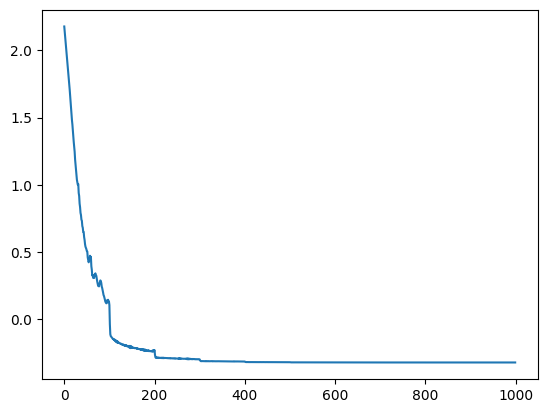

In [15]:
BCE_loss
plt.plot([math.log(x) for x in loss_record])

loss_fn(out_1, train_y1.reshape(-1,1))
loss_fn(out_2, train_y2.reshape(-1,1))
loss_fn(out_3, train_y3.reshape(-1,1))

In [16]:
model_1_all_linear1_params.reshape(1,-1)
model_2_all_linear1_params.reshape(1,-1)
model_3_all_linear1_params.reshape(1,-1)

tensor([[-1.2305e-01, -1.5889e-01, -2.0238e-01, -1.3304e-01, -1.6882e-01,
         -2.3716e-01, -9.3351e-02, -1.4887e-01, -1.6460e-01, -8.8173e-07,
          1.3112e-06,  7.6641e-07,  3.4975e-06,  3.9622e-08,  3.6648e-06,
          4.9875e-07, -1.5515e-06, -1.1723e-06, -1.7505e-06, -2.6581e-06,
          1.9825e-06, -4.2992e-07, -3.5057e-06, -1.4227e-06, -7.2578e-07,
         -3.1555e-06,  3.4289e-07, -5.8421e-03,  3.6715e-07, -1.6985e-06,
          7.5256e-07,  8.7719e-07,  2.2038e-06, -6.4457e-07, -1.2778e-06,
          1.6811e-06,  2.2407e-06,  2.8263e-06, -1.6102e-06, -3.1353e-06,
          3.2893e-06,  3.1711e-06, -2.2844e-06, -1.3651e-06, -9.3727e-07,
         -2.7086e-06, -8.2305e-07, -2.1254e-06, -1.4783e-06, -3.2050e-06,
          1.4806e-06,  1.0650e-06, -1.3599e-06, -1.8411e-06,  6.5597e-07,
         -2.5132e-06, -2.1462e-06,  2.8668e-06, -9.7198e-08,  1.0917e-06,
          2.8181e-06, -1.2946e-02, -1.2561e-03, -2.2112e-06, -6.0987e-07,
          5.1682e-07, -2.4345e-06,  3.

tensor([[-1.2305e-01, -1.5889e-01, -2.0238e-01, -1.3304e-01, -1.6882e-01,
         -2.3716e-01, -9.3351e-02, -1.4887e-01, -1.6460e-01, -8.8173e-07,
          1.3112e-06,  7.6641e-07,  3.4975e-06,  3.9622e-08,  3.6648e-06,
          4.9875e-07, -1.5515e-06, -1.1723e-06, -1.7505e-06, -2.6581e-06,
          1.9825e-06, -4.2992e-07, -3.5057e-06, -1.4227e-06, -7.2578e-07,
         -3.1555e-06,  3.4289e-07, -5.8421e-03,  3.6715e-07, -1.6985e-06,
          7.5256e-07,  8.7719e-07,  2.2038e-06, -6.4457e-07, -1.2778e-06,
          1.6811e-06,  2.2407e-06,  2.8263e-06, -1.6102e-06, -3.1353e-06,
          3.2893e-06,  3.1711e-06, -2.2844e-06, -1.3651e-06, -9.3727e-07,
         -2.7086e-06, -8.2305e-07, -2.1254e-06, -1.4783e-06, -3.2050e-06,
          1.4806e-06,  1.0650e-06, -1.3599e-06, -1.8411e-06,  6.5597e-07,
         -2.5132e-06, -2.1462e-06,  2.8668e-06, -9.7198e-08,  1.0917e-06,
          2.8181e-06, -1.2946e-02, -1.2561e-03, -2.2112e-06, -6.0987e-07,
          5.1682e-07, -2.4345e-06,  3.

tensor([[-1.8074e-01, -2.0465e-01, -2.3806e-01, -1.7833e-01,  2.7888e-01,
         -2.1915e-01, -1.7266e-01, -1.9078e-01, -1.9377e-01, -4.8615e-07,
         -3.4863e-07, -3.2098e-07, -5.2390e-08,  4.5079e-07, -1.8201e-07,
         -6.4788e-08, -1.4270e-06, -1.9219e-06, -3.7740e-07,  7.3093e-09,
          7.5498e-09, -4.2970e-07,  2.8469e-07, -7.5116e-08, -2.6917e-07,
          1.8637e-07, -2.3317e-07, -6.0918e-02,  6.7177e-08, -3.0756e-07,
         -1.6681e-07,  1.4637e-07,  5.5493e-08,  8.9271e-08, -1.9783e-06,
          1.0363e-06,  1.2211e-07, -5.1419e-07, -8.4728e-08,  2.5350e-08,
          7.3235e-08,  6.5821e-08, -1.4701e-08,  8.1056e-08,  3.9030e-07,
         -2.1774e-07,  4.9619e-07, -2.0839e-07,  3.9955e-08, -1.4965e-08,
         -9.8336e-08, -4.1324e-08,  2.6385e-08,  5.5969e-08,  3.1973e-07,
         -2.5629e-08, -2.3958e-07,  1.6702e-07,  2.6528e-07, -2.1152e-06,
          8.9448e-07, -1.1447e-01, -2.6937e-04,  1.7037e-07, -1.0513e-07,
         -5.3281e-07, -2.5056e-07,  1.

In [17]:

model_1(test_x1)[0].squeeze()
test_y1.squeeze()
model_2(test_x2)[0].squeeze()
test_y2.squeeze()
model_3(test_x3)[0].squeeze()
test_y3.squeeze()


tensor([0.9924, 0.6841, 0.0224, 0.6105, 0.9907, 0.1232, 0.1842, 0.0055, 0.0074,
        0.5741, 0.1211, 0.0045, 0.0028, 0.9643, 0.0287, 0.0062, 0.9881, 0.2385,
        0.7820, 0.4230, 0.9299, 0.9543, 0.6474, 0.0298, 0.9969, 0.9938, 0.6437,
        0.2140, 0.1066, 0.0785, 0.9655, 0.9855, 0.8133, 0.9942, 0.9929, 0.0100,
        0.8368, 0.0282, 0.5576, 0.0267], grad_fn=<SqueezeBackward0>)

tensor([1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
        1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0.,
        1., 0., 0., 0.])

tensor([7.5398e-01, 7.5162e-04, 5.1312e-02, 9.8769e-01, 1.0408e-03, 3.9538e-04,
        9.9781e-01, 2.1745e-02, 2.0131e-05, 9.9939e-01, 4.1323e-01, 9.9703e-01,
        9.3204e-01, 9.1193e-01, 3.0081e-01, 9.7488e-01, 8.9518e-01, 9.9769e-01,
        7.1174e-01, 4.6957e-03, 9.2042e-01, 1.4220e-03, 9.9063e-01, 8.8714e-01,
        9.5454e-01, 1.4294e-04, 9.9430e-01, 5.2268e-02, 8.2339e-03, 9.3312e-03,
        6.4341e-01, 8.3320e-04, 9.7575e-01, 9.4614e-01, 9.9160e-01, 9.9517e-01,
        2.7916e-01, 1.5926e-01, 9.9137e-01, 7.8393e-02],
       grad_fn=<SqueezeBackward0>)

tensor([0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1.,
        1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
        0., 0., 1., 0.])

tensor([1.3241e-02, 2.5408e-03, 7.9616e-01, 7.1108e-01, 9.5415e-01, 6.4027e-03,
        1.1828e-03, 9.6844e-01, 9.6253e-01, 7.3000e-01, 9.7357e-01, 4.2536e-04,
        1.9479e-03, 8.6088e-01, 7.3400e-04, 9.7963e-01, 6.6416e-01, 4.4335e-02,
        4.1633e-01, 5.8442e-02, 9.5653e-01, 2.1535e-01, 9.8213e-01, 2.1378e-01,
        9.8407e-03, 3.7403e-02, 4.3004e-03, 9.3820e-01, 9.8559e-01, 3.6365e-03,
        9.8125e-01, 4.7024e-01, 1.8085e-03, 9.7625e-01, 8.3025e-01, 1.0196e-01,
        6.1799e-01, 9.8514e-01, 8.4257e-01, 8.2089e-01],
       grad_fn=<SqueezeBackward0>)

tensor([0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0.,
        1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0.,
        0., 1., 1., 1.])

In [18]:
################## third step ##################
################## testing stage ##################

prediction_1= (model_1(test_x1)[0]>0.5).clone().int()
target_1= test_y1.reshape(-1,1).int()

prediction_2= (model_2(test_x2)[0]>0.5).clone().int()
target_2= test_y2.reshape(-1,1).int()

prediction_3= (model_3(test_x3)[0]>0.5).clone().int()
target_3= test_y3.reshape(-1,1).int()

prediction=np.append(prediction_1,prediction_2)
prediction=np.append(prediction,prediction_3)
prediction=prediction.tolist()

target=np.append(target_1,target_2)
target=np.append(target,target_3)
target=target.tolist()

final_matrix=confusion_matrix(target,prediction)
final_matrix
recall_score(target,prediction)#TPR
final_matrix[0,0]/(sum(final_matrix[0,:]))#TNR
accuracy_score(target,prediction)
precision_score(target,prediction)
f1_score(target,prediction)

array([[52,  8],
       [ 4, 56]])

0.9333333333333333

0.8666666666666667

0.9

0.875

0.9032258064516129

In [192]:
final_matrix_1=confusion_matrix(target_1,prediction_1)
final_matrix_1
recall_score(target_1,prediction_1)#TPR
final_matrix_1[0,0]/(sum(final_matrix_1[0,:]))#TNR

final_matrix_2=confusion_matrix(target_2,prediction_2)
final_matrix_2
recall_score(target_2,prediction_2)#TPR
final_matrix_2[0,0]/(sum(final_matrix_2[0,:]))#TNR

final_matrix_3=confusion_matrix(target_3,prediction_3)
final_matrix_3
recall_score(target_3,prediction_3)#TPR
final_matrix_3[0,0]/(sum(final_matrix_3[0,:]))#TNR

array([[17,  4],
       [ 3, 16]])

0.8421052631578947

0.8095238095238095

array([[12,  5],
       [ 4, 19]])

0.8260869565217391

0.7058823529411765

array([[20,  3],
       [ 1, 16]])

0.9411764705882353

0.8695652173913043

In [193]:
# variable selection evaluation

def cubic_root(x):
    return math.copysign(math.pow(abs(x), 1.0/3.0), x)

model_1_weight=model_1_all_linear1_params.detach().numpy().copy().reshape(1,-1)
model_2_weight=model_2_all_linear1_params.detach().numpy().copy().reshape(1,-1)
model_3_weight=model_3_all_linear1_params.detach().numpy().copy().reshape(1,-1)

model_1_weight
model_2_weight
model_3_weight

array([[-1.4729580e-01, -1.5461214e-01, -2.6040286e-01, -1.7491990e-01,
        -2.3177969e-01, -1.8083811e-01,  6.4288957e-07, -3.1841699e-02,
        -1.3782527e-01, -2.2228389e-07, -1.2016437e-06, -2.1685541e-06,
         2.3599555e-06,  8.2300204e-08, -1.5512943e-06, -1.6501492e-06,
        -1.9725451e-06, -3.0958563e-06, -6.2170398e-07,  1.1352673e-06,
         2.0300823e-07,  8.5518650e-08, -2.2167785e-06, -1.9611562e-06,
        -2.0857394e-06,  2.4923756e-06, -9.0075883e-07, -4.5609411e-02,
        -5.3072574e-07,  3.9823337e-07, -1.7664968e-06, -4.3879226e-07,
         3.3898114e-03,  9.3651670e-07, -2.2708869e-06,  1.9698214e-06,
        -7.1324365e-07, -6.7399031e-07, -3.0426577e-07,  1.7350670e-06,
         1.6648626e-07, -1.3622406e-06, -1.3327418e-06,  2.4421692e-07,
         4.3823738e-03, -6.5669548e-05,  4.5214850e-07, -1.3898893e-06,
         1.5947056e-06,  1.2850637e-06,  2.5683971e-06, -2.5818590e-06,
         2.0788486e-06, -1.4881490e-06,  8.8840306e-07,  6.69641

array([[-1.4729580e-01, -1.5461214e-01, -2.6040286e-01, -1.7491990e-01,
        -2.3177969e-01, -1.8083811e-01,  6.4288957e-07, -3.1841699e-02,
        -1.3782527e-01, -2.2228389e-07, -1.2016437e-06, -2.1685541e-06,
         2.3599555e-06,  8.2300204e-08, -1.5512943e-06, -1.6501492e-06,
        -1.9725451e-06, -3.0958563e-06, -6.2170398e-07,  1.1352673e-06,
         2.0300823e-07,  8.5518650e-08, -2.2167785e-06, -1.9611562e-06,
        -2.0857394e-06,  2.4923756e-06, -9.0075883e-07, -4.5609411e-02,
        -5.3072574e-07,  3.9823337e-07, -1.7664968e-06, -4.3879226e-07,
         3.3898114e-03,  9.3651670e-07, -2.2708869e-06,  1.9698214e-06,
        -7.1324365e-07, -6.7399031e-07, -3.0426577e-07,  1.7350670e-06,
         1.6648626e-07, -1.3622406e-06, -1.3327418e-06,  2.4421692e-07,
         4.3823738e-03, -6.5669548e-05,  4.5214850e-07, -1.3898893e-06,
         1.5947056e-06,  1.2850637e-06,  2.5683971e-06, -2.5818590e-06,
         2.0788486e-06, -1.4881490e-06,  8.8840306e-07,  6.69641

array([[-1.18810646e-01, -2.51877457e-01, -2.82472193e-01,
        -1.24300689e-01,  3.15098971e-01, -2.44625986e-01,
        -7.85258436e-08, -1.55563161e-01, -2.81405360e-01,
         1.90523195e-07, -9.73072247e-07, -1.62160660e-07,
         2.31896529e-08,  3.47473957e-07, -1.20812613e-08,
        -1.07352811e-08,  1.97738274e-07,  8.45165005e-07,
        -1.15874625e-08, -1.16290657e-07, -1.60355835e-08,
        -9.64175317e-09,  1.16833803e-07,  1.43071958e-07,
         1.17312780e-07, -2.29470544e-07, -1.68013321e-06,
         2.08560955e-02, -7.99739741e-09, -2.24825925e-07,
        -8.31474765e-08, -1.16955427e-07,  5.62622175e-02,
        -1.78547182e-07,  6.61880162e-10,  1.82679557e-07,
         2.77623371e-07, -2.09987533e-07, -3.83191292e-07,
        -3.03356899e-07, -5.84780310e-07,  4.74772264e-07,
         2.29536408e-08, -1.51521036e-07,  4.09187041e-02,
        -5.95576083e-03,  3.03826198e-07,  1.19227352e-07,
         1.80784028e-07, -3.01863778e-08, -3.02099778e-0

In [194]:
threshold=0.15
mcl_w=np.zeros(p)

for i in range(p):
    mcl_w[i]=cubic_root(model_1_weight[0,i]*model_2_weight[0,i]*model_3_weight[0,i])

max_mcl_w=max(abs(mcl_w))
for i in range(p):
    if (abs(mcl_w[i]))<=threshold*max_mcl_w:
        model_1_weight[0,i]=0
        model_2_weight[0,i]=0
        model_3_weight[0,i]=0
    else:
        model_1_weight[0,i]=model_1_weight[0,i]
        model_2_weight[0,i]=model_2_weight[0,i]
        model_3_weight[0,i]=model_3_weight[0,i]
index=np.nonzero(model_1_weight)[1]
model_1_weight
final_index=index+1
final_index
len(index)

array([[-0.1472958 , -0.15461214, -0.26040286, -0.1749199 , -0.2317797 ,
        -0.18083811,  0.        , -0.0318417 , -0.13782527,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        , -0.07188433,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

array([ 1,  2,  3,  4,  5,  6,  8,  9, 63])

9